# Scalable Machine Learning Image classifier on AWS Sagemaker

## Dataset Description

The dataset is small. It contains the following 20 categories:

- bike
- crab
- ipod
- license-plate
- owl
- playing-card
- raccoon
- smokestack
- spaghetti
- syringe
- chandelier
- grapes
- ketch
- octopus
- paperclip
- pyramid
- skateboard
- soda-can
- speed-boat
- umbrella

The training data contains the above-mentioned 20 categories, with 40 images in each category (800 images total). 

## AWS SDK and Required Function Setup

In [119]:
import os
import time
import boto3
import urllib.request
from boto3 import client
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from urllib.parse import urlparse
from IPython.display import Image

def download(lbl,url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        os.rename("/home/ec2-user/SageMaker/"+filename, "/home/ec2-user/SageMaker/train/"+lbl+"/"+filename)

def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)
    
bucket='challengeaws'

## Training Data Preparation

In [124]:

DATA_LBL=['bike','crab','ipod','license-plate','owl','playing-card','raccoon','smokestack','spaghetti','syringe','chandelier','grapes','ketch','octopus','paperclip','pyramid','skateboard','soda-can','speed-boat','umbrella']

# Infra readyness: before downloading start 

for dir_nam in DATA_LBL:
    if not os.path.exists('train/'+dir_nam):
        os.mkdir('train/'+dir_nam)

In [125]:
# Folder and URL is ready and tested, Now lets fill those folders

for lbl in DATA_LBL:
    idx=1
    while idx <= 40:
        frmtd_idx=format(idx, '04')
        url='https://els-challenge.s3.amazonaws.com/dataset/ic/'+lbl+'/'+lbl+str(frmtd_idx)+'.jpg'
        download(lbl,url)
        idx+=1


In [ ]:
# Executed in Shell
mkdir -p train_60
for i in train/*; do
    c=`basename $i`
    mkdir -p train_60/$c
    for j in `ls $i/*.jpg | shuf | head -n 30`; do
        mv $j train_60/$c/
    done
done


In [126]:
#Generating data rec file for training and validation dataset 
#If dont have im2rec.py tool, Download from next step

!python im2rec.py --list --recursive train train_60/
!python im2rec.py --list --recursive val train/

bike 0
chandelier 1
crab 2
grapes 3
ipod 4
ketch 5
license-plate 6
octopus 7
owl 8
paperclip 9
playing-card 10
pyramid 11
raccoon 12
skateboard 13
smokestack 14
soda-can 15
spaghetti 16
speed-boat 17
syringe 18
umbrella 19
bike 0
chandelier 1
crab 2
grapes 3
ipod 4
ketch 5
license-plate 6
octopus 7
owl 8
paperclip 9
playing-card 10
pyramid 11
raccoon 12
skateboard 13
smokestack 14
soda-can 15
spaghetti 16
speed-boat 17
syringe 18
umbrella 19


In [108]:
!wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py

--2019-07-15 18:57:08--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.60.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.60.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: ‘im2rec.py’

im2rec.py           100%[===================>]  15.47K  --.-KB/s    in 0.01s   

2019-07-15 18:57:08 (1.55 MB/s) - ‘im2rec.py’ saved [15838/15838]



In [127]:
# set training and testing channels and copy data and list files to s3 location

s3train = 's3://{}/train/'.format(bucket)
s3validation = 's3://{}/validation/'.format(bucket)

s3train_lst = 's3://{}/train_lst/'.format(bucket)
s3validation_lst = 's3://{}/validation_lst/'.format(bucket)

# upload the image files to train and validation channels
!aws s3 cp train_60 $s3train --recursive --quiet
!aws s3 cp train $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp train.lst $s3train_lst --quiet
!aws s3 cp val.lst $s3validation_lst --quiet

## Model Training Job

In [131]:
#4. Start training job. 
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

sess = sagemaker.Session()

role = get_execution_role()
print(role)

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_image)

s3_output_location = 's3://{}/output'.format(bucket)
ic = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

arn:aws:iam::099337348844:role/service-role/AmazonSageMaker-ExecutionRole-20190712T182157
685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest


In [134]:
#time for cool things finally!! hyperparameterssss!!

ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=257,
                             mini_batch_size=128,
                             epochs=2,
                             learning_rate=0.01,
                             top_k=2,
                             num_training_samples=15420,
                             resize = 256,
                             precision_dtype='float32')

train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

ic.fit(inputs=data_channels, logs=True)

2019-07-15 19:33:32 Starting - Starting the training job...
2019-07-15 19:33:45 Starting - Launching requested ML instances......
2019-07-15 19:34:45 Starting - Preparing the instances for training.........
2019-07-15 19:36:08 Downloading - Downloading input data...
2019-07-15 19:36:43 Training - Downloading the training image.....
Docker entrypoint called with argument(s): train
[07/15/2019 19:37:42 INFO 140216693700416] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[07/15/2019 19:37:42 INFO 140216693700416] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'lear

## Deploy to AWS Endpoint

In [135]:
# Time for even cooler things : Deploy : We have Validation Accuracy: 0.890625

ic_classifier = ic.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

--------------------------------------------------------------------------------------------------!

## Prediction from Endpoint

In [147]:
# Lets check one image first 

import json
import numpy as np
from PIL import Image
import requests
import io

url='https://els-challenge.s3.amazonaws.com/dataset/ic-test/40.jpg'
#url=https://els-challenge.s3.amazonaws.com/dataset/ic-test/3.jpg

im = Image.open(requests.get(url, stream=True).raw)
im = im.resize((224, 224), Image.ANTIALIAS) # we will resize to the same size of training set

imgByteArr = io.BytesIO()
im.save(imgByteArr, format='PNG')
imgByteArr = imgByteArr.getvalue()

ic_classifier.content_type = 'application/x-image'
result = json.loads(ic_classifier.predict(imgByteArr))

In [148]:
print(result) #hmm, Messy

[0.00043899117736145854, 0.0005580441793426871, 0.00018819968681782484, 3.61115307896398e-05, 0.00029282341711223125, 0.00466609001159668, 0.00012953650730196387, 0.00012600209447555244, 0.00016657213564030826, 0.0003798711986746639, 0.00013188204320613295, 0.004406976047903299, 0.00022524553060065955, 0.007148747332394123, 0.0005527172470465302, 0.0006518363952636719, 8.688564776093699e-06, 0.0007929421262815595, 6.966730143176392e-05, 0.9789349436759949, 9.468983819260757e-08, 2.851270721748733e-07, 9.836967507226291e-08, 3.744039389630416e-08, 2.515988057893992e-07, 5.408140282270324e-07, 2.770293576759286e-07, 3.256372949067554e-08, 1.1664544530276544e-07, 5.407093794929096e-07, 4.7912756429013825e-08, 9.490626240449274e-08, 1.7488643777596735e-07, 1.4972439430493978e-06, 5.47205907253101e-08, 3.692314010095288e-07, 3.4319498354307143e-07, 7.465739599865628e-07, 3.8274737335086684e-07, 1.538396077194193e-07, 3.7750223214061407e-07, 9.472830697632162e-08, 1.3516824992620968e-06, 1.4

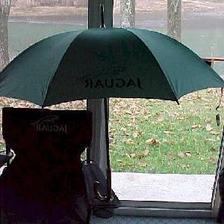

In [150]:
im

In [151]:
index = np.argmax(result)

In [152]:
DATA_LBL[index] #Done

'umbrella'

In [155]:
result[index] #Strong Confidence Level

0.9789349436759949

## Cleaning Up

It is very important to clean up the AWS resources that we are using after completion of the job. This includes the endpoints, the notebook instance, and the data stored in S3 bucket. 

In [157]:
ic_classifier.delete_endpoint()